Given an MA neuron with parameters $\tau_r$, $\tau_a$, $x_s$, $x_p$, the equivalent filters for a linear-nonlinear neuron with a rectifying nonlinearity $f(x) = \Theta(x)x$ are: 

$$h_s =\frac{x_s}{\gamma\tau_r}\exp(-t/\tau_a)  \left[ \exp\left( \gamma t\right) - 1 \right]
\quad \quad h_p =\frac{x_p}{\gamma\tau_r}\exp(-t/\tau_a)  \left[ \exp\left( \gamma t\right) - 1 \right]
\quad \quad \gamma = \frac{1}{\tau_a} - \frac{1}{\tau_r}$$

Note: for $\tau_a \approx \tau_r$ we have $\gamma \approx 0$ and 

$$h_s = \frac{x_s}{\tau_r} \exp(-t/\tau_a) t \quad \quad h_p = \frac{x_p}{\tau_r} \exp(-t/\tau_a) t$$

In [1]:
%matplotlib inline
from itertools import product as cprod
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.io import loadmat
from scipy import signal
import sys

from aux import loadmat_h5, get_seg, get_outliers, mv_avg
from disp import set_plot, plot_b

from record import smlt_ppln_ma, smlt_ppln_lnrelu, smlt_ppln_lin

cc = np.concatenate


T_MAX = 360
T = np.arange(T_MAX)
NROI = 20

T_SINE = np.array([5, 25, 45])
T_PULSE = np.array([65, 85, 105])
T_NAT = np.array([125, 195, 265])

SMOOTH = 3

EXPT = '220718_stim_2'
# EXPT = '220718_stim_3'
# EXPT = '220718_stim_6'  # oscillatory artifact?
# EXPT = '220805_stim_1'
# EXPT = '220805_stim_2'

DATA_DIR = f'data/original/lin_20220805/nat_song_imaging/{EXPT}/supervoxels/'
FNAME_STIM = 'data/original/lin_20220805/nat_song_imaging/blocks_plus3songs_forplotting.mat'


def ma_to_h_ln(tau_r, tau_a, x_s, x_p, dt):
    """Given a set of MA params, get LN filters that match MA step response."""
    th = np.arange(0, np.min([5*np.max([tau_r, tau_a]), 200]), dt)  # filter time vec
    gam = (1/tau_a) - (1/tau_r)
    
    if np.abs(gam) > 1e-8:
        r_step_s = x_s/(gam*tau_r) * np.exp(-th/tau_a) * (np.exp(gam*th) - 1)
        r_step_p = x_p/(gam*tau_r) * np.exp(-th/tau_a) * (np.exp(gam*th) - 1)
    else:
        r_step_s = x_s/tau_r * np.exp(-th/tau_a) * th
        r_step_p = x_p/tau_r * np.exp(-th/tau_a) * th
        
    h_s = np.gradient(r_step_s, dt)
    h_p = np.gradient(r_step_p, dt)
    
    return h_s, h_p, th

In [2]:
stims = loadmat(FNAME_STIM)
tstim_ = stims['stim_time'].flatten()
dt = np.mean(np.diff(tstim_))

mt_s_ = stims['sine_song'].flatten().astype(bool)
mt_p_ = stims['pulse_song'].flatten().astype(bool)

stim_ = np.zeros(len(tstim_), dtype=int)
stim_[mt_s_] = 1
stim_[mt_p_] = 2

tstim = np.arange(0, T_MAX, dt)

mt_s = np.zeros(len(tstim), dtype=bool)
mt_s[:len(mt_s_)] = mt_s_

mt_p = np.zeros(len(tstim), dtype=bool)
mt_p[:len(mt_p_)] = mt_p_

stim = np.zeros(len(tstim))
stim[:len(stim_)] = stim_

i_s = mt_s.astype(float)
i_p = mt_p.astype(float)

In [3]:
# MA neuron params
TAU_R = np.array([.5, 1, 2, 5, 10, 20, 30, 60])
TAU_A = np.array([1, 2, 5, 10, 20, 30, 60])
X_S = np.array([0, .2, .4, .6, .8, 1, -.2, -.4, -.6, -.8, -1])

tau_rs, tau_as, x_ss = np.transpose(list(cprod(TAU_R, TAU_A, X_S)))
x_ps = np.nan*np.zeros(len(x_ss))
x_ps[x_ss >= 0] = 1 - x_ss[x_ss >= 0]
x_ps[x_ss < 0] = -1 - x_ss[x_ss < 0]

# LN neuron params
h_ss = []
h_ps = []
ths = []

for tau_r, tau_a, x_s, x_p in zip(tau_rs, tau_as, x_ss, x_ps):
    h_s, h_p, th = ma_to_h_ln(tau_r, tau_a, x_s, x_p, dt)
    if np.any(np.isnan(h_s)):
        print(tau_r, tau_a, x_s, x_p)
    h_ss.append(h_s)
    h_ps.append(h_p)
    ths.append(th)

In [4]:
# compute population responses to presented stim
rs_ma = smlt_ppln_ma(i_s, i_p, tau_rs, tau_as, x_ss, x_ps, dt)

rs_ln = []
for x_s, x_p, h_s, h_p in zip(x_ss, x_ps, h_ss, h_ps):
    if x_s + x_p == 1:
        rs_ln.append(smlt_ppln_lnrelu(i_s, i_p, h_s[:, None], h_p[:, None], dt, sign=1)[:, 0])
    elif x_s + x_p == -1:
        rs_ln.append(smlt_ppln_lnrelu(i_s, i_p, h_s[:, None], h_p[:, None], dt, sign=-1)[:, 0])
    else:
        print('x_s + x_p \neq 1')
    
rs_ln = np.transpose(rs_ln)

In [5]:
# down-sample model responses
rs_ma_dn = np.transpose([signal.resample(r_ma, T_MAX) for r_ma in rs_ma.T])
rs_ln_dn = np.transpose([signal.resample(r_ln, T_MAX) for r_ln in rs_ln.T])

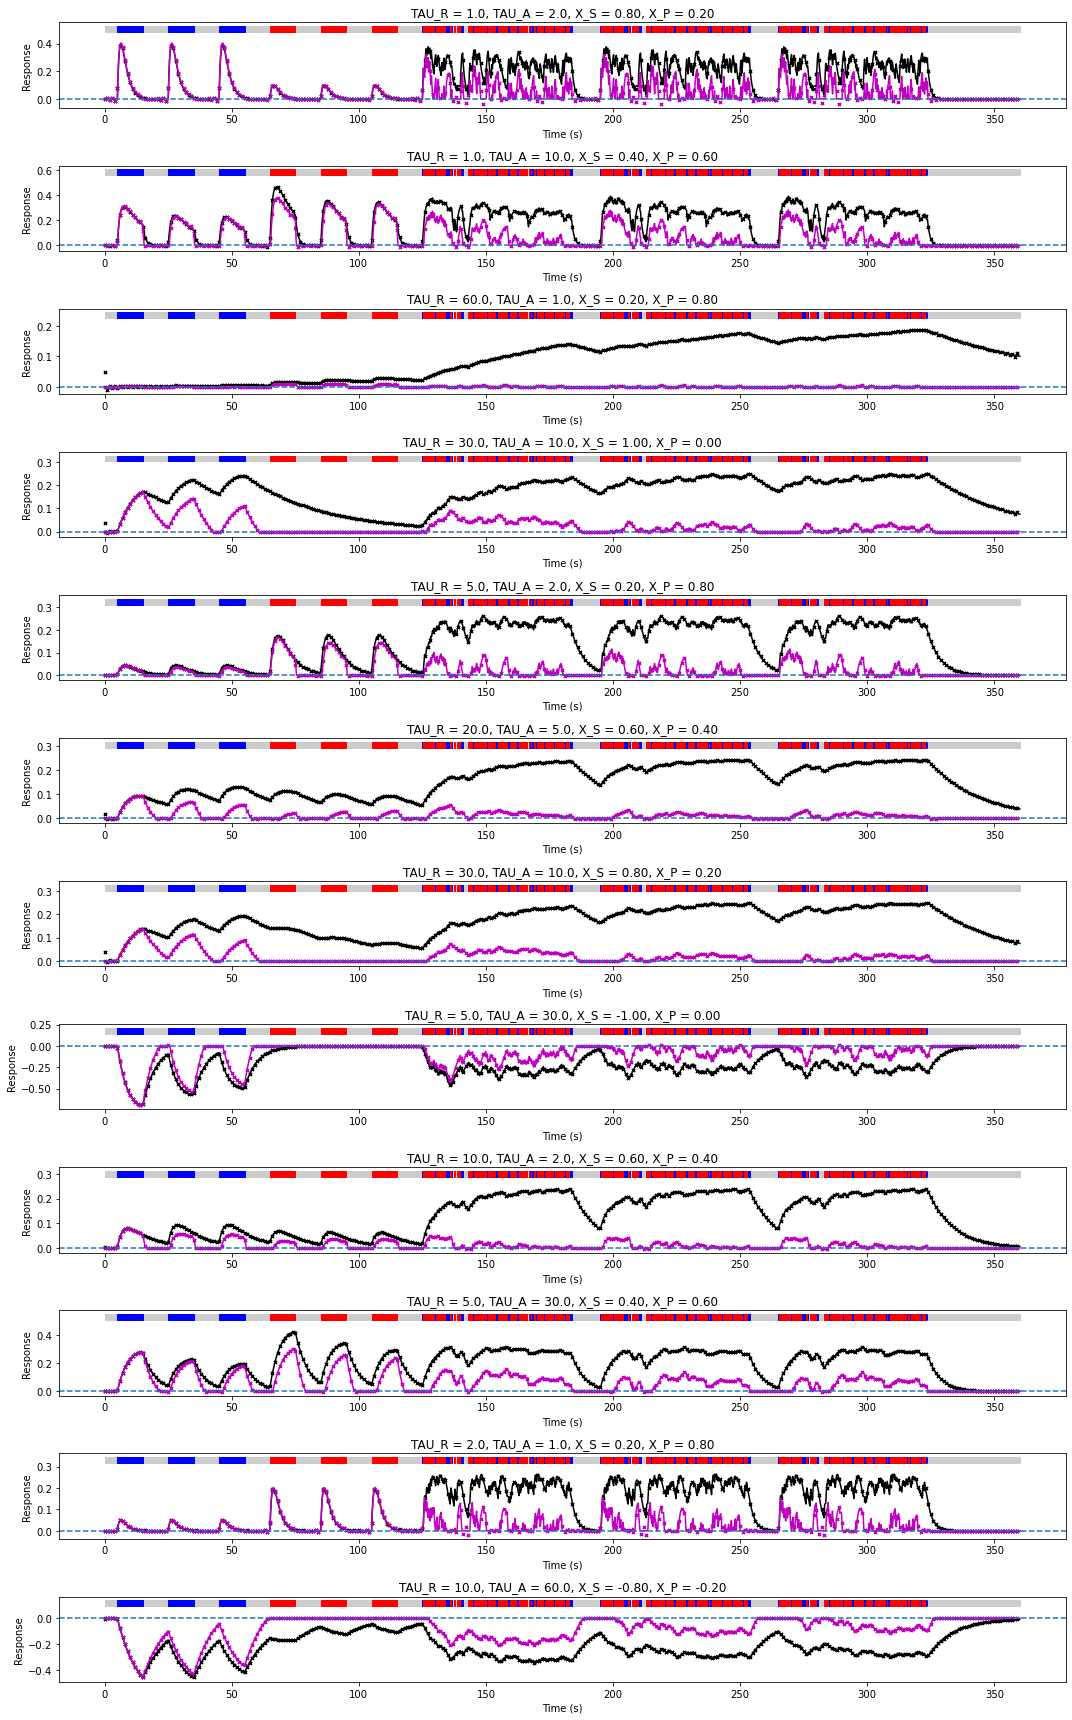

In [6]:
# plot several MA and corresponding LN responses
inrns_plot = np.random.randint(0, len(tau_rs), 12)
nplot = len(inrns_plot)

fig, axs = plt.subplots(nplot, 1, figsize=(15, 2*nplot), tight_layout=True)
for inrn, ax in zip(inrns_plot, axs):
    tau_r, tau_a, x_s, x_p = tau_rs[inrn], tau_as[inrn], x_ss[inrn], x_ps[inrn]
    
    r_ma = rs_ma[:, inrn]
    r_ln = rs_ln[:, inrn]
    
    ax.plot(tstim, r_ma, c='k')
    ax.plot(tstim, r_ln, c='m')
    
    ax.scatter(T, rs_ma_dn[:, inrn], c='k', s=10, marker='x')
    ax.scatter(T, rs_ln_dn[:, inrn], c='m', s=10, marker='x')
    
    ax.axhline(0, ls='--')
    
    r_min = cc([r_ma, r_ln]).min()
    r_max = cc([r_ma, r_ln]).max()
    
    lb = r_max + .2*(r_max-r_min)
    ub = r_max + .3*(r_max-r_min)
    
    plot_b(ax, tstim, stim, c=[(.8, .8, .8), 'b', 'r'], extent=[tstim[0], tstim[-1]+dt, lb, ub])
    set_plot(
        ax,  x_label='Time (s)', y_label='Response',
        title=f'TAU_R = {tau_r}, TAU_A = {tau_a}, X_S = {x_s:.2f}, X_P = {x_p:.2f}')

In [7]:
# z-score all model responses
rs_ma_dnz = (rs_ma_dn - rs_ma_dn.mean(0))/rs_ma_dn.std(0)
rs_ln_dnz = (rs_ln_dn - rs_ln_dn.mean(0))/rs_ln_dn.std(0)

In [8]:
mt_match = T < (T_NAT[0]-5)  # attempt to match block song responses
# mt_match = ((T_NAT[0]-5) <= T) & (T < (T_NAT[-1] + 5))  # attempt to match natural song responses

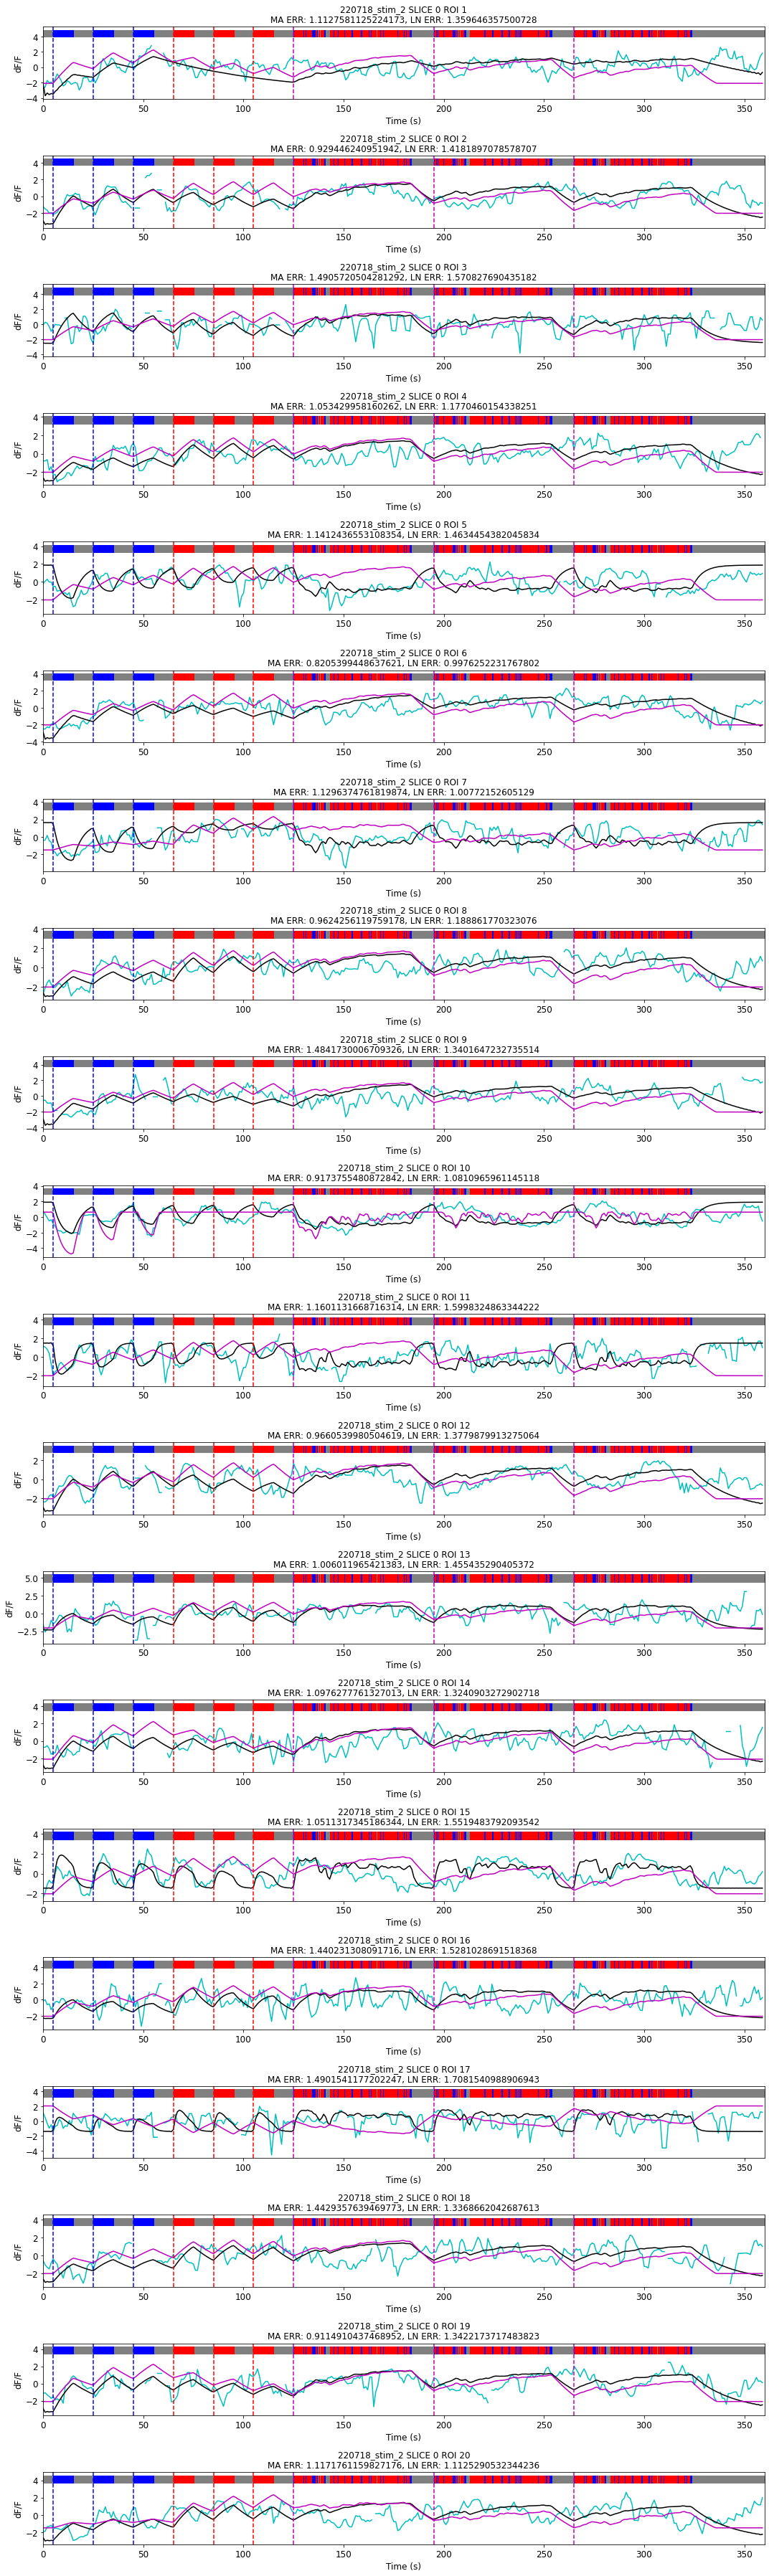

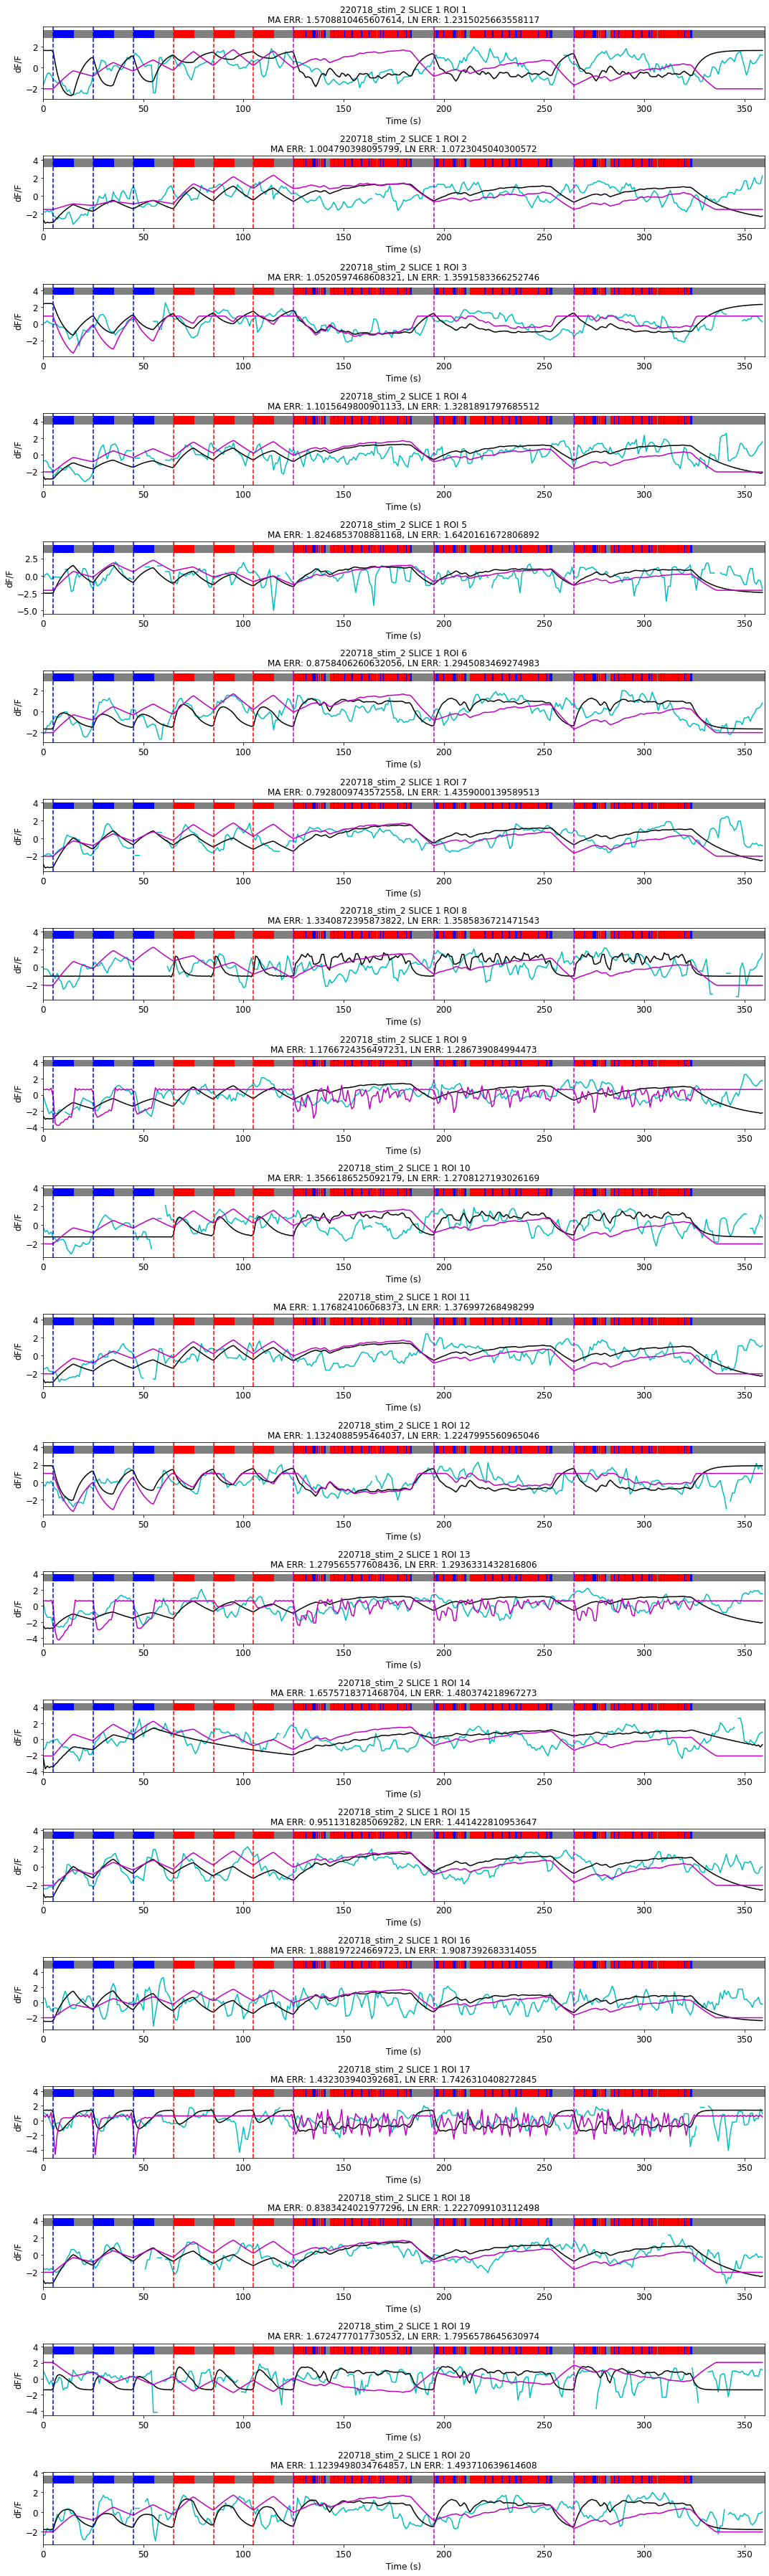

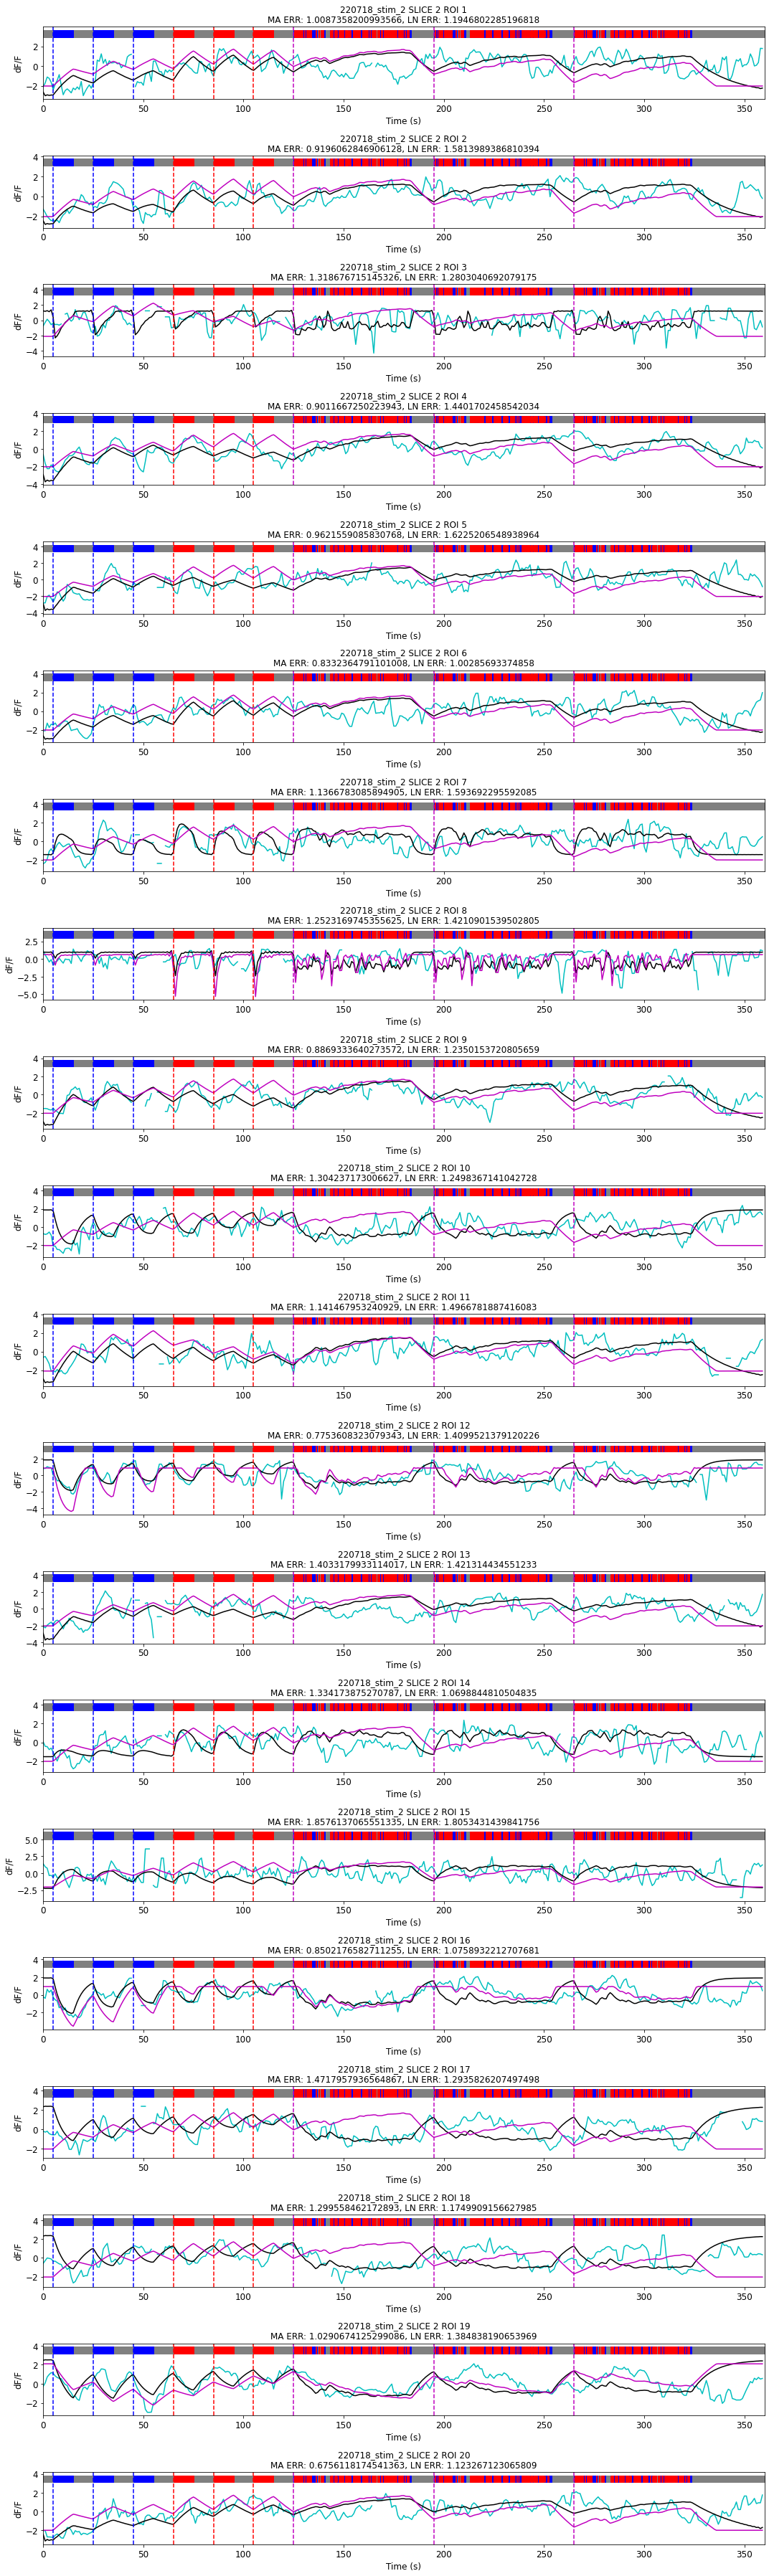

In [9]:
SLICE_PLOT = range(3)

errs_ma_all = []
errs_ln_all = []

for SLICE in range(9):
    FNAME = f'{EXPT}_n20_t360_slice{SLICE}.h5'
    z_dff = loadmat_h5(os.path.join(DATA_DIR, FNAME))['z_dff']

    dffs = []
    
    idxs_best_ma = []
    idxs_best_ln = []
    
    rs_best_ma = []
    rs_best_ln = []
    
    errs_ma = []
    errs_ln = []

    for dff in z_dff.T:

        dff[get_outliers(dff, 3)] = np.nan
        dff_smooth = mv_avg(T, dff, SMOOTH)
        
        # z-score
        dff_smooth -= np.nanmean(dff_smooth)
        dff_smooth /= np.nanstd(dff_smooth)

        dffs.append(dff_smooth)
        
        # find closest matching MA response
        err_ma = np.nanmean((rs_ma_dnz.T - dff_smooth)[:, mt_match]**2, axis=1)
        idx_best_ma = np.argmin(err_ma)
        errs_ma.append(err_ma[idx_best_ma])
        
        idxs_best_ma.append(idx_best_ma)
        rs_best_ma.append(rs_ma_dnz[:, idx_best_ma])
        
        err_ln = np.nanmean((rs_ln_dnz.T - dff_smooth)[:, mt_match]**2, axis=1)
        idx_best_ln = np.argmin(err_ln)
        errs_ln.append(err_ln[idx_best_ln])
        
        idxs_best_ln.append(idx_best_ln)
        rs_best_ln.append(rs_ln_dnz[:, idx_best_ln])

    errs_ma_all.append(errs_ma)
    errs_ln_all.append(errs_ln)
    
    # plot raw traces
    if SLICE in SLICE_PLOT:
        fig, axs = plt.subplots(NROI, 1, figsize=(15, 2.5*NROI), tight_layout=True)
        for croi, (ax, dff) in enumerate(zip(axs, dffs)):

            lb, ub = np.nanmin(dff), np.nanmax(dff)

            plot_b(ax, tstim, stim, extent=[0, tstim.max(), ub + .2*(ub-lb), ub + .35*(ub-lb)], c=['gray', 'b', 'r'])

            ax.plot(T, dff, c='c')
            ax.plot(T, rs_best_ma[croi], c='k')
            ax.plot(T, rs_best_ln[croi], c='m')

            for t in T_SINE:
                ax.axvline(t, color='b', ls='--')
            for t in T_PULSE:
                ax.axvline(t, color='r', ls='--')
            for t in T_NAT:
                ax.axvline(t, color='m', ls='--')

            set_plot(ax, x_lim=(0, T_MAX), x_label='Time (s)', y_label='dF/F', title=f'{EXPT} SLICE {SLICE} ROI {croi+1}\nMA ERR: {errs_ma[croi]}, LN ERR: {errs_ln[croi]}', font_size=12)

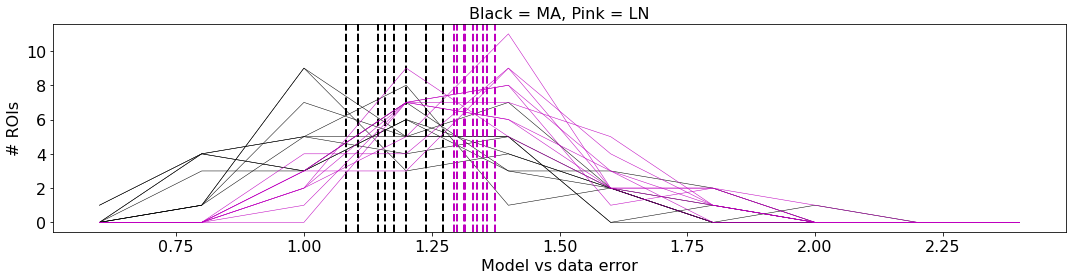

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4), tight_layout=True)
bins = np.linspace(.5, 2.5, 11)
binc = .5*(bins[:-1] + bins[1:])

for errs_ma in errs_ma_all:
    cts = np.histogram(errs_ma, bins)[0]
    ax.plot(binc, cts, c='k', lw=.5)
    ax.axvline(np.median(errs_ma), c='k', lw=2, ls='--')

for errs_ln in errs_ln_all:
    cts = np.histogram(errs_ln, bins)[0]
    ax.plot(binc, cts, c='m', lw=.5)
    ax.axvline(np.median(errs_ln), c='m', lw=2, ls='--')
    
set_plot(ax, x_label='Model vs data error', y_label='# ROIs', title='Black = MA, Pink = LN', font_size=16)